In [1]:
import pandas as pd
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings("ignore")

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync')


In [2]:
# conversions
veh_name_remap = {'combination long-haul truck':'combination long-haul truck',
                  'combination short-haul truck': 'combination short-haul truck',
                  'single-unit short-haul truck': 'single unit short-haul truck',
                 'single-unit long-haul truck': 'single unit long-haul truck',
                  'light commercial truck':  'light commercial truck'}

sut_ct_label = {'combination long-haul truck':'combination truck',
                  'combination short-haul truck': 'combination truck',
                  'single unit short-haul truck': 'single unit truck',
                 'single unit long-haul truck': 'single unit truck'}

hauling_label = {'combination long-haul truck':'long-haul',
                  'combination short-haul truck': 'short-haul',
                  'single unit short-haul truck': 'short-haul',
                 'single unit long-haul truck': 'long-haul'}

MOVES_fuel_lookup = {1: 'Gasoline', 
                    2: 'Diesel',
                    3: 'CNG',
                    5: 'Other',
                    9: 'Electricity'}

VIUS_fuel_lookup = {'Gasoline': 'Gasoline', 
                    'Diesel': 'Diesel',
                    'Compressed natural gas': 'CNG',
                    'Propane': 'Other',
                    'Combination': 'Other',
                    'Liquified natural gas': 'Other',
                    'Alcohol fuels': 'Other',
                    'Electricity': 'Electricity'}

regclass_lookup = {30:'LDT', 41:'LHD2b3', 
                   42:'LHD45', 46:'MHD67',
                   47:'HHD8 (w. glider)', 
                   49:'HHD8 (w. glider)'}


#age bin related
age_bin = [-1, 3, 5, 7, 9, 14, 19, 31]

age_bin_label = ['age<=3', '3<age<=5','5<age<=7', 
                 '7<age<=9', '9<age<=14', '14<age<=19', 'age>=20']

age_bin_order = {'age<=3':1, '3<age<=5':2, '5<age<=7':3, 
                 '7<age<=9':4, '9<age<=14':5, 
                 '14<age<=19':6, 'age>=20':7}

order_of_col =  ['light commercial truck', 
                 'single unit short-haul truck',
                 'single unit long-haul truck', 
                 'combination short-haul truck',
                 'combination long-haul truck']  

order_of_reg = ['LDT', 'LHD2b3', 'LHD45', 'MHD67', 'HHD8 (w. glider)']

# Part 1 - data processing and generating summary statistics

In [4]:
# load MOVES data
MOVES_data_path = 'RawData/MOVES/MOVES_VMT_fraction_with_fuel_com_only.csv'
MOVES_fleet = read_csv(MOVES_data_path)

# load vius data
vius_data_path = 'RawData/US_VIUS_2021/vius_2021_com_crosswalk_20240624.csv'
vius_fleet = read_csv(vius_data_path)
print('vius sample size')
print(len(vius_fleet))

# additional distribution data
regclass_distribution = pd.read_excel('RawData/MOVES/moves_definition.xlsx', 
                                      sheet_name = 'fuel_type_distribution')
regclass_distribution.head(5)

vius sample size
38584


,sourceTypeModelYearID,sourceTypeID,modelYearID,fuelTypeID,engTechID,regClassID,stmyFuelEngFraction,stmyFraction
0,111960,11,1960,1,1,10,1.0,1.0
1,111961,11,1961,1,1,10,1.0,1.0
2,111962,11,1962,1,1,10,1.0,1.0
3,111963,11,1963,1,1,10,1.0,1.0
4,111964,11,1964,1,1,10,1.0,1.0


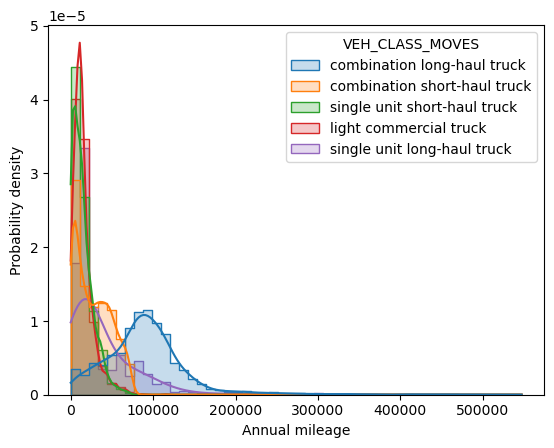

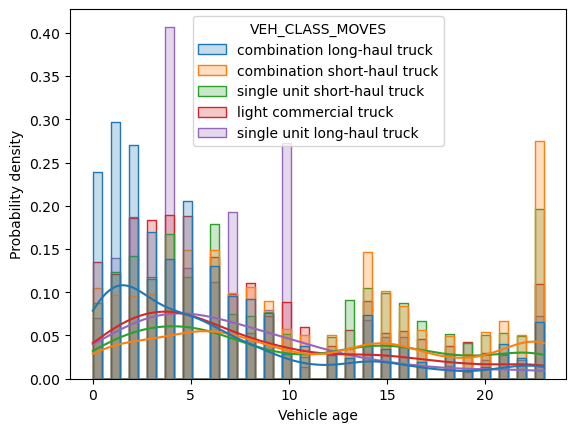

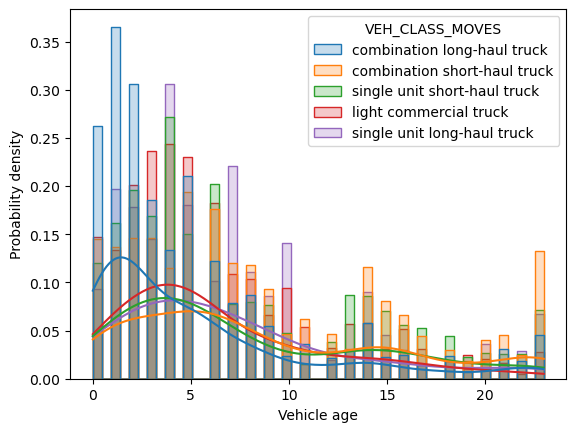

In [5]:
# post-process VIUS and MOVES data

# weighted VMT
vius_fleet.loc[:, 'WGT_VMT'] = \
vius_fleet.loc[:, 'TABWEIGHT'] * vius_fleet.loc[:, 'MILESANNL']

# vehicle age
vius_fleet.loc[:, 'VEH_AGE'] = \
2021 - vius_fleet.loc[:, 'MODELYEAR']

vius_fleet.loc[:, 'AGE_BIN'] = \
pd.cut(vius_fleet.loc[:, 'VEH_AGE'], 
       bins=age_bin, right=True, labels=age_bin_label)

# rename MOVES type name
vius_fleet['VEH_CLASS_MOVES'] = \
vius_fleet['VEH_CLASS_MOVES'].str.lower()
vius_fleet.loc[:, 'VEH_CLASS_MOVES'] = \
vius_fleet.loc[:, 'VEH_CLASS_MOVES'].map(veh_name_remap)

MOVES_fleet.loc[:, 'AGE_BIN'] = \
pd.cut(MOVES_fleet.loc[:, 'ageID'], 
       bins=age_bin, right=True, labels=age_bin_label)

MOVES_fleet['sourceTypeName'] = \
MOVES_fleet['sourceTypeName'].str.lower()

sns.histplot(data=vius_fleet, 
             x="MILESANNL", weights = 'TABWEIGHT',
             stat = 'density', 
             hue="VEH_CLASS_MOVES", element="step",
             bins = 50, kde = True,
             common_norm = False)
plt.xlabel('Annual mileage')
plt.ylabel('Probability density')
plt.savefig('RawData/MOVES/plot/annual_mileage_VIUS.png', dpi = 300)
plt.show()

sns.histplot(data=vius_fleet, 
             x="VEH_AGE", weights = 'TABWEIGHT',
             stat = 'density', 
             hue="VEH_CLASS_MOVES", element="step",
             bins = 50, kde = True,
             common_norm = False)
plt.xlabel('Vehicle age')
plt.ylabel('Probability density')
plt.savefig('RawData/MOVES/plot/age_distribution_by_count_VIUS.png', dpi = 300)
plt.show()

sns.histplot(data=vius_fleet, 
             x="VEH_AGE", weights = 'WGT_VMT',
             stat = 'density', 
             hue="VEH_CLASS_MOVES", element="step",
             bins = 50, kde = True,
             common_norm = False)
plt.xlabel('Vehicle age')
plt.ylabel('Probability density')
plt.savefig('RawData/MOVES/plot/age_distribution_by_VMT_VIUS.png', dpi = 300)
plt.show()

In [6]:
# assign regulatory class 
# assign regular class to VIUS data
vius_fleet.loc[:, 'regClassID'] = 0
# LDT
vius_fleet.loc[vius_fleet['GVWR_CLASS'].isin(['1', '2A']), 'regClassID'] = 30
# LHD2B3
vius_fleet.loc[vius_fleet['GVWR_CLASS'].isin(['2B', '3']), 'regClassID'] = 41
# LHD45
vius_fleet.loc[vius_fleet['GVWR_CLASS'].isin(['4', '5']), 'regClassID'] = 42
# MHD67
vius_fleet.loc[vius_fleet['GVWR_CLASS'].isin(['6', '7']), 'regClassID'] = 46
# HHD8 (including glider)
vius_fleet.loc[vius_fleet['GVWR_CLASS'].isin(['8']), 'regClassID'] = 47
print(vius_fleet.regClassID.unique())

[47 46 42 41 30]


In [7]:
# add regular class to MOVES results
regclass_distribution = \
regclass_distribution[['sourceTypeID', 'modelYearID', 'fuelTypeID',	'regClassID', 'stmyFuelEngFraction']]
regclass_distribution = regclass_distribution.drop_duplicates(keep = 'first')
MOVES_fleet = pd.merge(MOVES_fleet, regclass_distribution,
                      on = ['sourceTypeID', 'modelYearID', 'fuelTypeID'],
                      how = 'left')
MOVES_fleet.loc[:, 'population_by_year_class'] = MOVES_fleet.loc[:, 'population_by_year'] * \
MOVES_fleet.loc[:, 'stmyFuelEngFraction'] * MOVES_fleet.loc[:, 'stmyFraction']

MOVES_fleet.loc[:, 'vmt_fraction'] = MOVES_fleet.loc[:, 'vmt_fraction'] * \
MOVES_fleet.loc[:, 'stmyFuelEngFraction']

MOVES_fleet.loc[:, 'weighted_vmt_by_hpms'] = MOVES_fleet.loc[:, 'weighted_vmt_by_hpms'] * \
MOVES_fleet.loc[:, 'stmyFuelEngFraction']

MOVES_fleet.head(5)

,sourceTypeID,ageID,HPMSVtypeID,sourceTypeName,HPMSVtypeName,sourceTypePopulation,ageFraction,modelYearID,population_by_year,weighted_vmt_by_hpms,vmt_fraction,fuelTypeID,stmyFraction,fuelTypeDesc,AGE_BIN,regClassID,stmyFuelEngFraction,population_by_year_class
0,32,0,25,light commercial truck,Light Duty Vehicles,13361293,0.072527,2021,969057.624335,9.291954e+09,0.019530,1,0.778959,Gasoline,age<=3,30,0.830981,627271.683153
1,32,0,25,light commercial truck,Light Duty Vehicles,13361293,0.072527,2021,969057.624335,1.889949e+09,0.003972,1,0.778959,Gasoline,age<=3,41,0.169019,127584.769199
2,32,0,25,light commercial truck,Light Duty Vehicles,13361293,0.072527,2021,969057.624335,2.810686e+07,0.000059,2,0.061317,Diesel Fuel,age<=3,30,0.031932,1897.408732
3,32,0,25,light commercial truck,Light Duty Vehicles,13361293,0.072527,2021,969057.624335,8.520985e+08,0.001791,2,0.061317,Diesel Fuel,age<=3,41,0.968068,57522.592632
4,32,0,25,light commercial truck,Light Duty Vehicles,13361293,0.072527,2021,969057.624335,2.235398e+09,0.004698,5,0.155723,Ethanol (E-85),age<=3,30,1.000000,150904.940120


In [8]:
# assign name tag to regulatory classes
MOVES_fleet.loc[:, 'regClassName'] = \
MOVES_fleet.loc[:, 'regClassID'].map(regclass_lookup)

print(MOVES_fleet.loc[:, 'regClassName'].unique())

vius_fleet.loc[:, 'regClassName'] = \
vius_fleet.loc[:, 'regClassID'].map(regclass_lookup)

print(vius_fleet.loc[:, 'regClassName'].unique())

['LDT' 'LHD2b3' 'LHD45' 'MHD67' 'HHD8 (w. glider)']
['HHD8 (w. glider)' 'MHD67' 'LHD45' 'LHD2b3' 'LDT']


## median age by count and VMT

In [9]:
# median of age
def weighted_median_by_count(df):
    df_sorted = df.sort_values('VEH_AGE')
    cumsum = df_sorted['TABWEIGHT'].cumsum()
    cutoff = df_sorted['TABWEIGHT'].sum() / 2.
    median = df_sorted[cumsum >= cutoff]['VEH_AGE'].iloc[0]
    return(median)
    
def weighted_median_by_vmt(df):
    df_sorted = df.sort_values('VEH_AGE')
    cumsum = df_sorted['WGT_VMT'].cumsum()
    cutoff = df_sorted['WGT_VMT'].sum() / 2.
    median = df_sorted[cumsum >= cutoff]['VEH_AGE'].iloc[0]
    return(median)

median_age_by_count = vius_fleet.groupby(['GVWR_CLASS']).apply(weighted_median_by_count)
median_age_by_count = median_age_by_count.reset_index()
median_age_by_vmt = vius_fleet.groupby(['GVWR_CLASS']).apply(weighted_median_by_vmt)
median_age_by_vmt = median_age_by_vmt.reset_index()
median_age = pd.merge(median_age_by_count, median_age_by_vmt, on = 'GVWR_CLASS')
median_age.columns = ['GVWR_CLASS', 'median_by_count', 'median_by_VMT']

median_age.to_csv('RawData/US_VIUS_2021/VIUS_truck_median_age.csv')
median_age.head(5)
print('vius fleet wide median by count is:')
print(weighted_median_by_count(vius_fleet))
print('vius fleet wide median by vmt is:')
print(weighted_median_by_vmt(vius_fleet))

vius_fleet_no_ldv = vius_fleet.loc[vius_fleet['VEH_CLASS_MOVES'] != 'light commercial truck']
print('vius fleet wide median by count (no LDV) is:')
print(weighted_median_by_count(vius_fleet_no_ldv))
print('vius fleet wide median by vmt (no LDV) is:')
print(weighted_median_by_vmt(vius_fleet_no_ldv))

vius fleet wide median by count is:
6
vius fleet wide median by vmt is:
5
vius fleet wide median by count (no LDV) is:
7
vius fleet wide median by vmt (no LDV) is:
5


In [10]:
median_age_by_count = vius_fleet.groupby(['VEH_CLASS_MOVES']).apply(weighted_median_by_count)
median_age_by_count = median_age_by_count.reset_index()
median_age_by_vmt = vius_fleet.groupby(['VEH_CLASS_MOVES']).apply(weighted_median_by_vmt)
median_age_by_vmt = median_age_by_vmt.reset_index()
count_and_vmt = vius_fleet.groupby(['VEH_CLASS_MOVES'])[['TABWEIGHT', 'WGT_VMT']].sum()
count_and_vmt = count_and_vmt.reset_index()

median_age = pd.merge(median_age_by_count, median_age_by_vmt, on = 'VEH_CLASS_MOVES')
median_age = pd.merge(median_age, count_and_vmt, on = 'VEH_CLASS_MOVES')
median_age.columns = ['VEH_CLASS_MOVES', 'median_by_count', 'median_by_VMT',
                     'Total vehicle', 'Total VMT']

median_age.to_csv('RawData/US_VIUS_2021/VIUS_truck_median_age_by_moves.csv')
median_age.head(5)

def weighted_median_by_count_moves(df):
    df_sorted = df.sort_values('ageID')
    cumsum = df_sorted['population_by_year_class'].cumsum()
    cutoff = df_sorted['population_by_year_class'].sum() / 2.
    median = df_sorted[cumsum >= cutoff]['ageID'].iloc[0]
    return(median)
    
def weighted_median_by_vmt_moves(df):
    df_sorted = df.sort_values('ageID')
    cumsum = df_sorted['weighted_vmt_by_hpms'].cumsum()
    cutoff = df_sorted['weighted_vmt_by_hpms'].sum() / 2.
    median = df_sorted[cumsum >= cutoff]['ageID'].iloc[0]
    return(median)
median_age_by_count = MOVES_fleet.groupby(['sourceTypeName']).apply(weighted_median_by_count_moves)
median_age_by_count = median_age_by_count.reset_index()
median_age_by_vmt = MOVES_fleet.groupby(['sourceTypeName']).apply(weighted_median_by_vmt_moves)
median_age_by_vmt = median_age_by_vmt.reset_index()
count_and_vmt = MOVES_fleet.groupby(['sourceTypeName'])[['population_by_year_class', 'weighted_vmt_by_hpms']].sum()
count_and_vmt = count_and_vmt.reset_index()

median_age = pd.merge(median_age_by_count, median_age_by_vmt, on = 'sourceTypeName')
median_age = pd.merge(median_age, count_and_vmt, on = 'sourceTypeName')
median_age.columns = ['VEH_CLASS_MOVES', 'median_by_count', 'median_by_VMT',
                     'Total vehicle', 'Total VMT']

median_age.to_csv('RawData/US_VIUS_2021/MOVES_truck_median_age_by_moves.csv')
median_age.head(5)

print('MOVES fleet wide median by count is:')
print(weighted_median_by_count_moves(MOVES_fleet))
print('MOVES fleet wide median by vmt is:')
print(weighted_median_by_vmt_moves(MOVES_fleet))

MOVES_fleet_no_ldv = MOVES_fleet.loc[MOVES_fleet['sourceTypeName'] != 'light commercial truck']
print('MOVES MHD median by count is:')
print(weighted_median_by_count_moves(MOVES_fleet_no_ldv))
print('MOVES MHD median by vmt is:')
print(weighted_median_by_vmt_moves(MOVES_fleet_no_ldv))

MOVES fleet wide median by count is:
8
MOVES fleet wide median by vmt is:
4
MOVES MHD median by count is:
11
MOVES MHD median by vmt is:
4


In [11]:
# median age by hauling mode
haul_mode_lookup = {0: 'long-haul (daily mileage >=200)', 
                    1: 'short-haul (daily mileage <200)'}
vius_fleet.loc[:, 'HAUL_MODE'] = \
vius_fleet.loc[:, 'SHORT_HAUL'].map(haul_mode_lookup)

median_age_by_count = \
vius_fleet.groupby(['GVWR_CLASS', 'HAUL_MODE']).apply(weighted_median_by_count)
median_age_by_count = median_age_by_count.reset_index()
median_age_by_vmt = \
vius_fleet.groupby(['GVWR_CLASS', 'HAUL_MODE']).apply(weighted_median_by_vmt)
median_age_by_vmt = median_age_by_vmt.reset_index()

sample_size = vius_fleet.groupby(['GVWR_CLASS', 'HAUL_MODE']).size()
sample_size.columns = ['sample_size']
sample_size = sample_size.reset_index()
median_age = pd.merge(median_age_by_count, median_age_by_vmt, 
                      on = ['GVWR_CLASS', 'HAUL_MODE'])
median_age = pd.merge(median_age, sample_size, 
                      on = ['GVWR_CLASS', 'HAUL_MODE'])
median_age.columns = ['GVWR_CLASS', 'HAUL_MODE', 
                      'median_by_count', 'median_by_VMT', 'sample_size']

median_age.to_csv('RawData/US_VIUS_2021/MOVES_truck_median_age_by_haul.csv')
median_age.head(5)

,GVWR_CLASS,HAUL_MODE,median_by_count,median_by_VMT,sample_size
0,1,long-haul (daily mileage >=200),4,4,48
1,1,short-haul (daily mileage <200),5,5,661
2,2A,long-haul (daily mileage >=200),5,5,59
3,2A,short-haul (daily mileage <200),6,5,778
4,2B,long-haul (daily mileage >=200),10,6,130


# Part 2 - collecting fleet distribution from VIUS

In [12]:
# collect truck count by state
vius_fleet_by_state = pd.pivot_table(vius_fleet,
                                     index = 'REGSTATE',
                                     columns = 'GVWR_CLASS',
                                     values = 'TABWEIGHT',
                                     aggfunc = 'sum')
vius_fleet_by_state = vius_fleet_by_state.reset_index()
vius_fleet_by_state.to_csv('RawData/US_VIUS_2021/VIUS_truck_count_by_state.csv',
                          index = False)
vius_fleet_by_state.head(5)

GVWR_CLASS,REGSTATE,1,2A,2B,3,4,5,6,7,8
0,Alabama,121494.4,198457.9,23971.7,24096.6,4819.1,7330.1,9733.0,7001.2,38067.6
1,Alaska,18779.2,28475.1,17038.5,3083.6,1481.0,2293.6,1209.4,1356.6,7113.3
2,Arizona,140747.3,194854.2,95034.7,11831.5,3480.8,8350.5,5312.9,7529.0,42878.9
3,Arkansas,46393.5,142409.4,33436.0,19647.3,6920.3,4195.9,4791.6,4710.5,31402.7
4,California,1891528.0,1426343.6,219701.9,200032.8,45801.9,81354.4,80299.9,34927.9,285435.6


## sample size and population

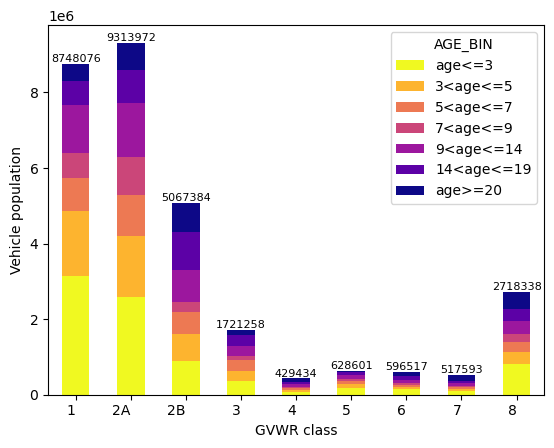

In [13]:
# summary cross-tab for VIUS
def generate_cross_tab_summary(df, ind_attr, col_attr, col_order, 
                               val_attr, xlabel, ylabel, plot_file, funcform = 'sum'):
    df_wide = pd.pivot_table(df,
                                         index = ind_attr,
                                         columns = col_attr,
                                         values = val_attr,
                                         aggfunc = funcform)
    df_wide = df_wide.fillna(0)
    df_wide = df_wide[col_order]
    bar_sums = df_wide.sum(axis=1)
    
    df_wide.plot(kind = 'bar', stacked = True, cmap= 'plasma_r')
    plt.xticks(rotation = 0, ha = 'right')
    
    # Annotate the bars with their sums
    for i, sum_val in enumerate(bar_sums):
        sum_val = int(sum_val)
        plt.text(i, sum_val, str(sum_val), ha='center', va='bottom', fontsize = 8)
    # plt.legend(bbox_to_anchor = (1.01, 0.5))
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.savefig('RawData/MOVES/plot/' + plot_file, dpi = 300, bbox_inches = 'tight')
    plt.show()
# plot population by class
generate_cross_tab_summary(vius_fleet, 'GVWR_CLASS', 'AGE_BIN', age_bin_label, 
                               'TABWEIGHT', 'GVWR class', 'Vehicle population', 
                           'VIUS_pop_by_class_and_age.png', funcform = 'sum')

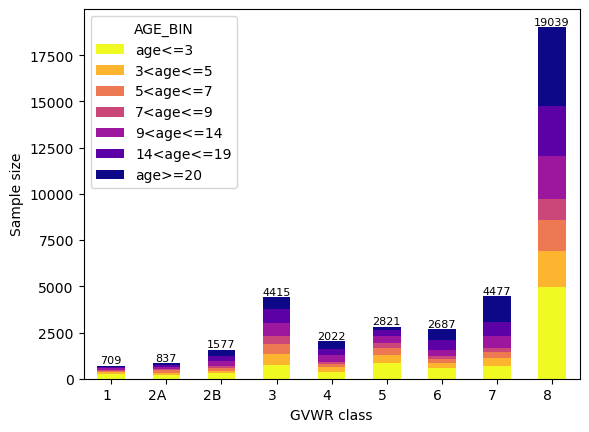

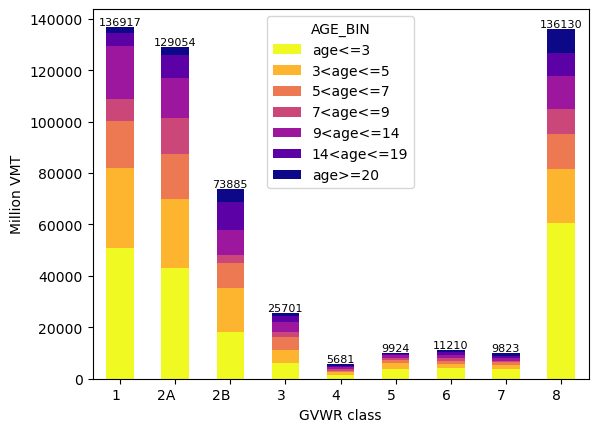

In [14]:
# plot sample size by class
generate_cross_tab_summary(vius_fleet, 'GVWR_CLASS', 'AGE_BIN', age_bin_label, 
                               'TABWEIGHT', 'GVWR class', 'Sample size', 
                           'VIUS_size_by_class_and_age.png', funcform = 'count')

# plot VMT by class
vius_fleet.loc[:, 'WGT_VMT_Million'] = vius_fleet.loc[:, 'WGT_VMT'] / 1000000
generate_cross_tab_summary(vius_fleet, 'GVWR_CLASS', 'AGE_BIN', age_bin_label, 
                               'WGT_VMT_Million', 'GVWR class', 'Million VMT', 
                           'VIUS_VMT_by_class_and_age.png', funcform = 'sum')

## survey responses

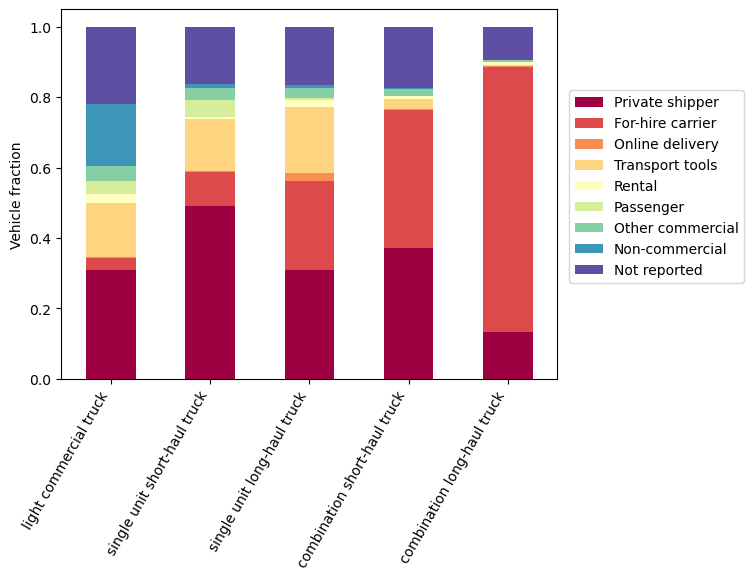

In [15]:
# Primary use by MOVES type
name_conv = \
{"Transporting goods/products belonging to owner or owner's company": 'Private shipper',
 'Transporting goods/products belonging to another person/company': 'For-hire carrier',
 'Not reported': 'Not reported',
 'Transporting paying passengers': 'Passenger',
 "Transporting tools related to owner's business": 'Transport tools',
 'Other commercial activity':'Other commercial',
 'Rental (daily and other short term)': 'Rental',
 'Transporting non-paying passengers': 'Passenger',
 'Non-commercial use': 'Non-commercial',
 'Transporting online local goods/products': 'Online delivery'}

vius_fleet.loc[:, 'BUSINESS_TYPE'] = \
vius_fleet.loc[:, 'PRIMCOMMACT'].map(name_conv)
vius_fleet_by_use = pd.pivot_table(vius_fleet,
                                     index = 'VEH_CLASS_MOVES',
                                     columns = 'BUSINESS_TYPE',
                                     values = 'TABWEIGHT',
                                     aggfunc = 'sum')
vius_fleet_by_use = vius_fleet_by_use.fillna(0)
# vius_fleet_by_use.plot(kind = 'bar', stacked = True)
# plt.xticks(rotation = 30, ha = 'right')
# plt.legend(bbox_to_anchor = (1.01, 0.8))
# plt.ylabel('Vehicle population')
# plt.xlabel('')
# plt.show()

vius_fleet_by_use_frac = vius_fleet_by_use.copy()
use_label = vius_fleet.BUSINESS_TYPE.unique()
vius_fleet_by_use_frac.loc[:, use_label] = \
    vius_fleet_by_use_frac.loc[:, use_label].div(vius_fleet_by_use_frac.loc[:, use_label].sum(axis=1), axis=0)
order_of_row = ['Private shipper', 'For-hire carrier', 'Online delivery',
                'Transport tools', 'Rental', 'Passenger', 
                'Other commercial', 'Non-commercial', 'Not reported']
vius_fleet_by_use_frac = vius_fleet_by_use_frac.loc[order_of_col]
vius_fleet_by_use_frac = vius_fleet_by_use_frac[order_of_row]

vius_fleet_by_use_frac.plot(kind = 'bar', stacked = True, cmap = 'Spectral')
plt.xticks(rotation = 60, ha = 'right')
plt.legend(bbox_to_anchor = (1.01, 0.8))
plt.ylabel('Vehicle fraction')
plt.xlabel('')
plt.savefig('RawData/MOVES/plot/MOVES_source_type_by_usage.png',
           dpi = 300, bbox_inches = 'tight')
plt.show()

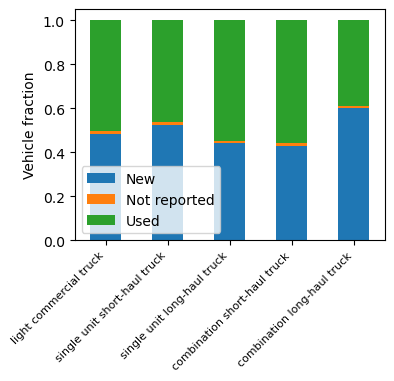

In [16]:
# ownership by MOVES type
vius_fleet_by_use = pd.pivot_table(vius_fleet,
                                     index = 'VEH_CLASS_MOVES',
                                     columns = 'ACQUISITION',
                                     values = 'TABWEIGHT',
                                     aggfunc = 'sum')
vius_fleet_by_use = vius_fleet_by_use.fillna(0)
# vius_fleet_by_use = vius_fleet_by_use.loc[order_of_col]
# vius_fleet_by_use.plot(kind = 'bar', stacked = True)
# plt.xticks(rotation = 30, ha = 'right')
# plt.legend(bbox_to_anchor = (1.01, 0.8))
# plt.ylabel('Vehicle population')
# plt.xlabel('')
# plt.show()
vius_fleet_by_use_frac = vius_fleet_by_use.copy()
use_label = vius_fleet.ACQUISITION.unique()
vius_fleet_by_use_frac.loc[:, use_label] = \
    vius_fleet_by_use_frac.loc[:, use_label].div(vius_fleet_by_use_frac.loc[:, use_label].sum(axis=1), axis=0)
vius_fleet_by_use_frac = vius_fleet_by_use_frac.loc[order_of_col]


vius_fleet_by_use_frac.plot(kind = 'bar', stacked = True, figsize = (4,3))
plt.xticks(rotation = 45, ha = 'right', fontsize = 8)
plt.legend(loc=3)
plt.ylabel('Vehicle fraction')
plt.xlabel('')
plt.savefig('RawData/MOVES/plot/MOVES_source_type_by_ownership.png',
           dpi = 300, bbox_inches = 'tight')
plt.show()

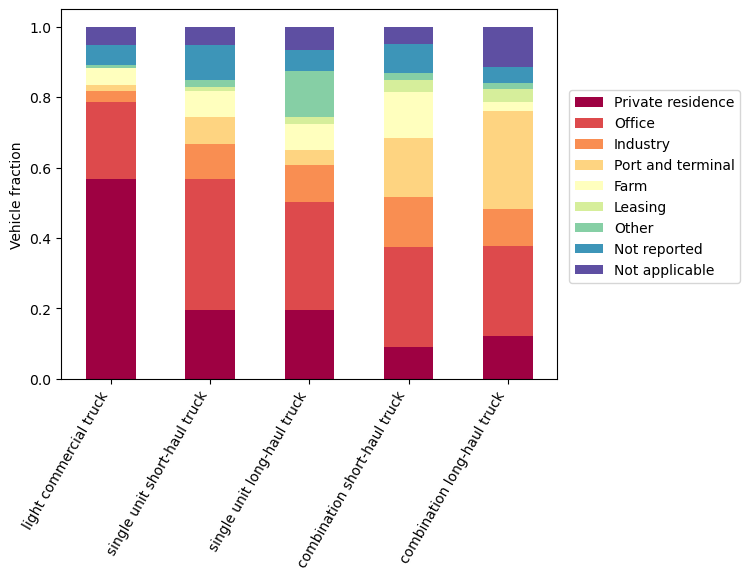

In [17]:
# home base by MOVES type
# print(vius_fleet.HBTYPE.unique())
hb_type_mapping = {'Corporate office/headquarters': 'Office',
                   'Not reported': 'Not reported',
                   "Not applicable (see 'Applicable Vehicles')": 'Not applicable',
                   'Manufacturing plant': 'Industry',
                   'Distribution center': 'Industry',
                   'Private residence': 'Private residence',
                   'Terminal or motor pool': 'Port and terminal',
                   'Farm/agricultural production': 'Farm',
                   'Mining or other energy production site': 'Industry',
                   'Port': 'Port and terminal', 
                   'Other': 'Other',
                   'Truck leasing company': 'Leasing'}

vius_fleet.loc[:, 'HBGROUP'] = vius_fleet.loc[:, 'HBTYPE'].map(hb_type_mapping)
vius_fleet_by_hb = pd.pivot_table(vius_fleet,
                                     index = 'VEH_CLASS_MOVES',
                                     columns = 'HBGROUP',
                                     values = 'TABWEIGHT',
                                     aggfunc = 'sum')
vius_fleet_by_hb = vius_fleet_by_hb.fillna(0)

# vius_fleet_by_hb.plot(kind = 'bar', stacked = True, cmap = 'Paired')
# plt.xticks(rotation = 30, ha = 'right')
# plt.legend(bbox_to_anchor = (1.01, 0.8))
# plt.ylabel('Vehicle population')
# plt.xlabel('')
# plt.show()
vius_fleet_by_hb_frac = vius_fleet_by_hb.copy()
use_label = vius_fleet.HBGROUP.unique()
vius_fleet_by_hb_frac.loc[:, use_label] = \
    vius_fleet_by_hb_frac.loc[:, use_label].div(vius_fleet_by_hb_frac.loc[:, use_label].sum(axis=1), axis=0)
order_of_row = ['Private residence', 'Office', 'Industry',
                'Port and terminal', 'Farm', 'Leasing',
                'Other', 'Not reported', 'Not applicable']
vius_fleet_by_hb_frac = vius_fleet_by_hb_frac[order_of_row]
vius_fleet_by_hb_frac = vius_fleet_by_hb_frac.loc[order_of_col]

vius_fleet_by_hb_frac.plot(kind = 'bar', stacked = True, cmap = 'Spectral')
plt.xticks(rotation = 60, ha = 'right')
plt.legend(bbox_to_anchor = (1.01, 0.8))
plt.ylabel('Vehicle fraction')
plt.xlabel('')
plt.savefig('RawData/MOVES/plot/MOVES_source_type_by_homebase.png',
           dpi = 300, bbox_inches = 'tight')
plt.show()

192920


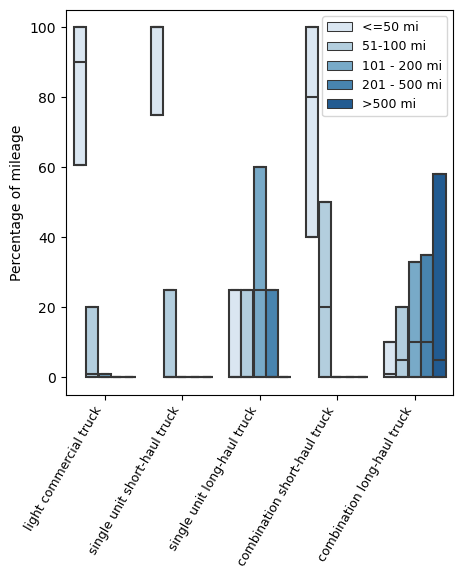

In [18]:
# range of operation by MOVES type
range_lookup = {'RO_0_50':'<=50 mi', 
                'RO_51_100': '51-100 mi',
                'RO_101_200': '101 - 200 mi', 
                'RO_201_500': '201 - 500 mi',
                'RO_GT500':'>500 mi'}
vius_fleet_by_ro = pd.melt(vius_fleet,
                           id_vars = ['ID', 'VEH_CLASS_MOVES', 'TABWEIGHT'],
                           value_vars=['RO_0_50', 'RO_51_100',
                                       'RO_101_200', 'RO_201_500',
                                      'RO_GT500'], 
                           var_name='range', value_name='fraction')
print(len(vius_fleet_by_ro))
# print(vius_fleet_by_ro.fraction.unique())
vius_fleet_by_ro = vius_fleet_by_ro.reset_index()
vius_fleet_by_ro.loc[:, 'Operation_range'] = \
vius_fleet_by_ro.loc[:, 'range'].map(range_lookup)
vius_fleet_by_ro.head(5)
vius_fleet_by_ro = \
vius_fleet_by_ro.loc[vius_fleet_by_ro['fraction'] != 'Not Reported']

vius_fleet_by_ro['fraction'] = vius_fleet_by_ro['fraction'].astype(float)

st_code =  {'light commercial truck':32, 
                 'single unit short-haul truck': 52,
                 'single unit long-haul truck': 53, 
                 'combination short-haul truck': 61,
                 'combination long-haul truck': 62}  
vius_fleet_by_ro.loc[:, 'st_code'] = \
vius_fleet_by_ro.loc[:, 'VEH_CLASS_MOVES'].map(st_code)
vius_fleet_by_ro = vius_fleet_by_ro.sort_values(by = 'st_code', ascending = True)
plt.figure(figsize = (5,5))
sns.boxplot(data=vius_fleet_by_ro, x="VEH_CLASS_MOVES", y="fraction",
           hue = 'Operation_range', showfliers = False, whis=0,
            hue_order = ['<=50 mi', '51-100 mi', '101 - 200 mi', '201 - 500 mi','>500 mi'],
            palette = 'Blues')
plt.xticks(rotation = 60, ha = 'right', fontsize = 9)
plt.ylabel('Percentage of mileage')
plt.xlabel('')
plt.legend(loc=1, fontsize = 9)
plt.savefig('RawData/MOVES/plot/MOVES_source_type_by_range.png',
           dpi = 300, bbox_inches = 'tight')
plt.show()

# Part 3 - comparison of fleet composition

In [19]:
# plot func
def plot_clustered_stacked(dfall, labels, title, ylabelname, H="//", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""
    plt.figure(figsize = (5.5, 4.5))
    # plt.rcParams['hatch.color'] = 'k'
    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    axe = plt.subplot(111)

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=0,
                      stacked=True, edgecolor='k',
                      ax=axe,
                      legend=False,
                      grid=False, cmap= 'plasma_r',
                      **kwargs)  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch(H * int(i / n_col)) #edited part     
                rect.set_width(1 / float(n_df + 1))

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)
    axe.set_title(title)

    # Add invisible data to add another legend
    n=[]        
    for i in range(n_df):
        n.append(axe.bar(0, 0, color="gray", hatch=H * i * 2, edgecolor='k'))

    l1 = axe.legend(h[:n_col], l[:n_col], 
                    bbox_to_anchor=(0.99, 1), loc="upper left", fontsize = 8)
    if labels is not None:
        l2 = plt.legend(n, labels, loc=[1.01, 0.1]) 
    axe.add_artist(l1)
    plt.xticks(rotation = 45, ha = 'right', fontsize = 10)
    plt.ylabel(ylabelname)
    plt.xlabel('')
    plt.tight_layout()
    
    return axe

## truck type and hauling mode by count

In [20]:
# compare veh count by MOVES source type


MOVES_count_by_st = \
MOVES_fleet.groupby('sourceTypeName')[['sourceTypePopulation']].mean()
MOVES_count_by_st = MOVES_count_by_st.reset_index()

vius_count_by_st = \
vius_fleet.groupby('VEH_CLASS_MOVES')[['TABWEIGHT']].sum()
vius_count_by_st = vius_count_by_st.reset_index()

# generate veh count comparison
MOVES_count_by_st.columns = ['Vehicle type', 'Count']
MOVES_count_by_st.loc[:, 'Source'] = 'MOVES'

vius_count_by_st.columns = ['Vehicle type', 'Count']
vius_count_by_st.loc[:, 'Source'] = '2021 US VIUS'

truck_count_comparison = \
pd.concat([MOVES_count_by_st, vius_count_by_st])

In [26]:
truck_count_comparison.to_csv('RawData/MOVES/MOVES_VIUS_truck_count.csv', index = False)

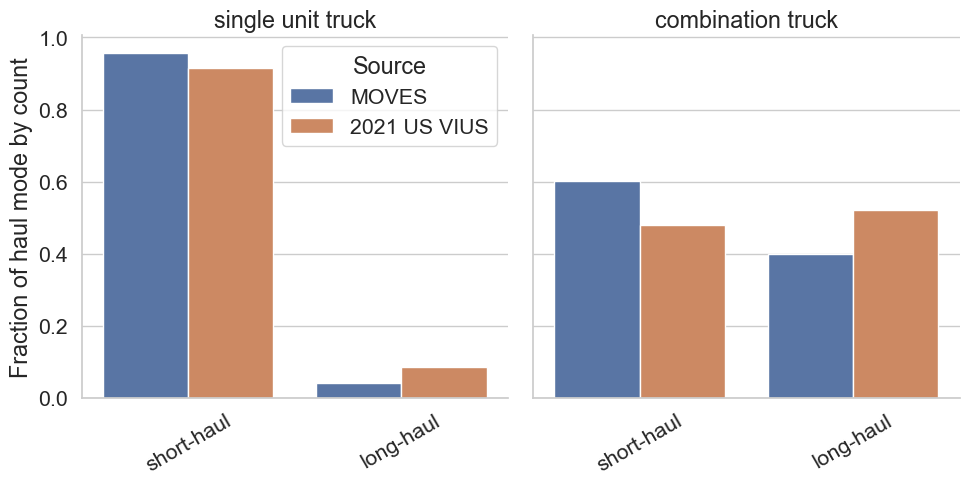

,Vehicle type,Count,Source,truck_category,hauling_mode,hauling_frac
0,combination long-haul truck,1255024.0,MOVES,combination truck,long-haul,0.399246
1,combination short-haul truck,1888460.0,MOVES,combination truck,short-haul,0.600754
3,single unit long-haul truck,398330.0,MOVES,single unit truck,long-haul,0.042241
4,single unit short-haul truck,9031555.0,MOVES,single unit truck,short-haul,0.957759
0,combination long-haul truck,1103533.9,2021 US VIUS,combination truck,long-haul,0.520354
1,combination short-haul truck,1017204.8,2021 US VIUS,combination truck,short-haul,0.479646
3,single unit long-haul truck,410060.8,2021 US VIUS,single unit truck,long-haul,0.085794
4,single unit short-haul truck,4369522.7,2021 US VIUS,single unit truck,short-haul,0.914206


In [21]:
# hauling fraction by category

# drop LDT
truck_count_comparison = \
truck_count_comparison.loc[truck_count_comparison["Vehicle type"] != 
'light commercial truck']
truck_count_comparison.loc[:, 'truck_category'] =\
truck_count_comparison.loc[:, 'Vehicle type'].map(sut_ct_label)
truck_count_comparison.loc[:, 'hauling_mode'] =\
truck_count_comparison.loc[:, 'Vehicle type'].map(hauling_label)

truck_count_comparison.loc[:, 'hauling_frac'] = \
truck_count_comparison.loc[:, 'Count'] /\
truck_count_comparison.groupby(['Source', 'truck_category'])['Count'].transform('sum')

sns.set(font_scale=1.4)  # larger font 
veh_order = ['single unit truck', 'combination truck']
haul_order = ['short-haul', 'long-haul']
sns.set_style("whitegrid")
ax = sns.catplot(truck_count_comparison, 
            x="hauling_mode", y="hauling_frac", 
            hue="Source", col = 'truck_category', 
                 order = haul_order, col_order = veh_order, kind = 'bar',
            errorbar = None, legend_out=False)
ax.set_ylabels('Fraction of haul mode by count')
ax.set_xlabels('')
ax.set_titles("{col_name}")
# plt.xticks(rotation = 30, ha= 'right')
for axn in ax.axes.flat:
    for label in axn.get_xticklabels():
        label.set_rotation(30)

plt.savefig('RawData/MOVES/plot/truck_hauling_frac_by_type.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()
truck_count_comparison

## truck type and hauling mode by VMT

In [22]:
# compare veh VMT by MOVES source type

MOVES_VMT_by_st = \
MOVES_fleet.groupby('sourceTypeName')[['weighted_vmt_by_hpms']].sum()
MOVES_VMT_by_st = MOVES_VMT_by_st.reset_index()
print(MOVES_VMT_by_st['sourceTypeName'].unique())

vius_VMT_by_st = \
vius_fleet.groupby('VEH_CLASS_MOVES')[['WGT_VMT']].sum()
vius_VMT_by_st = vius_VMT_by_st.reset_index()

MOVES_VMT_by_st.columns = ['Vehicle type', 'VMT']
MOVES_VMT_by_st.loc[:, 'Source'] = 'MOVES'

vius_VMT_by_st.columns = ['Vehicle type', 'VMT']
vius_VMT_by_st.loc[:, 'Source'] = '2021 US VIUS'

truck_VMT_comparison = \
pd.concat([MOVES_VMT_by_st, vius_VMT_by_st])

['combination long-haul truck' 'combination short-haul truck'
 'light commercial truck' 'single unit long-haul truck'
 'single unit short-haul truck']


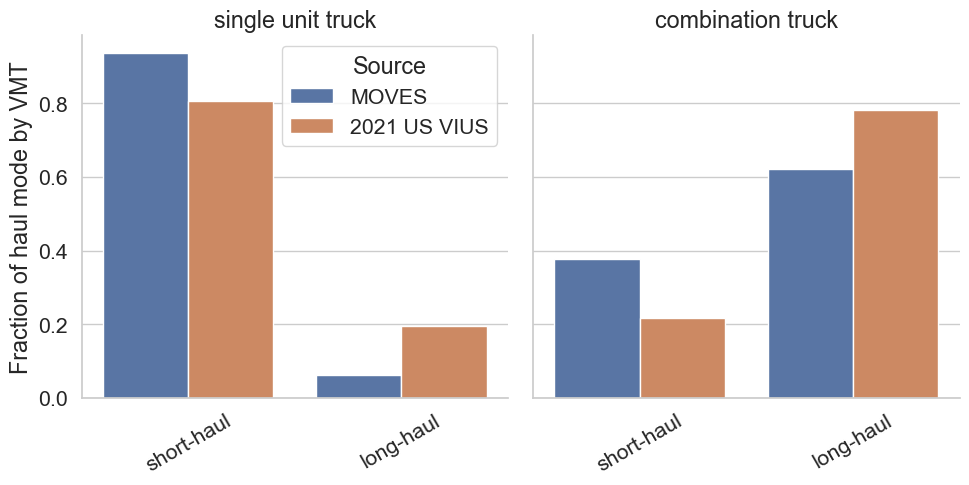

,Vehicle type,VMT,Source,truck_category,hauling_mode,hauling_vmt_frac
0,combination long-haul truck,1.215862e+11,MOVES,combination truck,long-haul,0.621556
1,combination short-haul truck,7.402966e+10,MOVES,combination truck,short-haul,0.378444
3,single unit long-haul truck,7.781689e+09,MOVES,single unit truck,long-haul,0.062666
4,single unit short-haul truck,1.163949e+11,MOVES,single unit truck,short-haul,0.937334
0,combination long-haul truck,9.952676e+10,2021 US VIUS,combination truck,long-haul,0.782960
1,combination short-haul truck,2.758929e+10,2021 US VIUS,combination truck,short-haul,0.217040
3,single unit long-haul truck,1.498806e+10,2021 US VIUS,single unit truck,long-haul,0.194743
4,single unit short-haul truck,6.197535e+10,2021 US VIUS,single unit truck,short-haul,0.805257


In [23]:
# hauling VMT fraction by category
truck_VMT_comparison = \
pd.concat([MOVES_VMT_by_st, vius_VMT_by_st])
truck_VMT_comparison = \
truck_VMT_comparison.loc[truck_VMT_comparison["Vehicle type"] != 
'light commercial truck']
truck_VMT_comparison.loc[:, 'truck_category'] =\
truck_VMT_comparison.loc[:, 'Vehicle type'].map(sut_ct_label)
truck_VMT_comparison.loc[:, 'hauling_mode'] =\
truck_VMT_comparison.loc[:, 'Vehicle type'].map(hauling_label)

truck_VMT_comparison.loc[:, 'hauling_vmt_frac'] = \
truck_VMT_comparison.loc[:, 'VMT'] /\
truck_VMT_comparison.groupby(['Source', 'truck_category'])['VMT'].transform('sum')
sns.set(font_scale=1.4)  # larger font 
veh_order = ['single unit truck', 'combination truck']
haul_order = ['short-haul', 'long-haul']
sns.set_style("whitegrid")
ax = sns.catplot(truck_VMT_comparison, 
            x="hauling_mode", y="hauling_vmt_frac", 
            hue="Source", col = 'truck_category', 
            order = haul_order, col_order = veh_order, kind = 'bar',
            errorbar = None, legend_out = False)
# plt.xticks(rotation = 30, ha= 'right')
ax.set_ylabels('Fraction of haul mode by VMT')
ax.set_xlabels('')
ax.set_titles("{col_name}")
for axn in ax.axes.flat:
    for label in axn.get_xticklabels():
        label.set_rotation(30)
        
plt.savefig('RawData/MOVES/plot/truck_hauling_vmt_frac_by_type.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()
truck_VMT_comparison

## truck type and age distribution by count

In [27]:
# plot ST MY distribution

MOVES_fleet_selected = \
MOVES_fleet[['sourceTypeName', 'ageID', 'AGE_BIN', 'fuelTypeID', 'regClassID', 'population_by_year_class']]
MOVES_fleet_selected = MOVES_fleet_selected.drop_duplicates(keep = 'first')


MOVES_count_by_stmy = pd.pivot_table(MOVES_fleet_selected, index = 'sourceTypeName',
                                  columns = 'AGE_BIN', values = 'population_by_year_class',
                                  aggfunc = 'sum')

MOVES_count_by_stmy = MOVES_count_by_stmy.reset_index()
print(MOVES_count_by_stmy['sourceTypeName'].unique())
# MOVES_count_by_st

vius_count_by_stmy = pd.pivot_table(vius_fleet, index = 'VEH_CLASS_MOVES',
                                  columns = 'AGE_BIN', values = 'TABWEIGHT',
                                  aggfunc = 'sum')
vius_count_by_stmy = vius_count_by_stmy.reset_index()

vius_count_by_stmy = \
vius_count_by_stmy.rename(columns = {'VEH_CLASS_MOVES': 'sourceTypeName'})


vius_count_by_stmy = vius_count_by_stmy.set_index('sourceTypeName')
MOVES_count_by_stmy = MOVES_count_by_stmy.set_index('sourceTypeName')

vius_count_by_stmy.head(5)

['combination long-haul truck' 'combination short-haul truck'
 'light commercial truck' 'single unit long-haul truck'
 'single unit short-haul truck']


AGE_BIN,14<age<=19,3<age<=5,5<age<=7,7<age<=9,9<age<=14,age<=3,age>=20
sourceTypeName,,,,,,,
combination long-haul truck,64925.3,174227.5,114457.5,85143.0,97057.2,495792.6,71930.8
combination short-haul truck,149947.9,106478.9,115963.5,91461.3,159162.9,185011.0,209179.3
light commercial truck,2460112.1,3967055.6,2505471.6,1927552.3,3493056.2,6568186.5,1919421.1
single unit long-haul truck,25119.4,101009.2,57594.3,24794.7,77403.9,97089.3,27050.0
single unit short-haul truck,698101.2,572531.3,509318.0,300641.1,645162.6,941465.6,702302.9


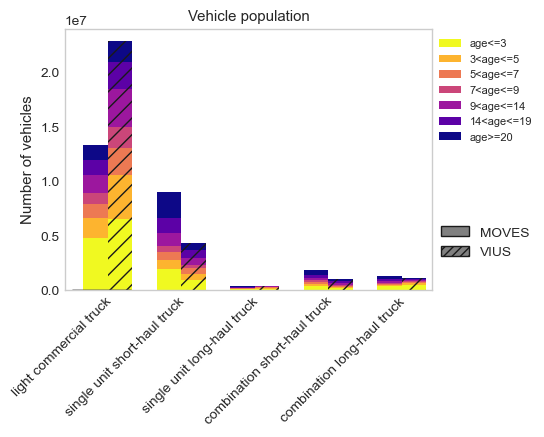

In [28]:
# plot stacked bar chart
vius_count_by_stmy = vius_count_by_stmy[age_bin_label]
vius_count_by_stmy = vius_count_by_stmy.loc[order_of_col]

MOVES_count_by_stmy = MOVES_count_by_stmy[age_bin_label]
MOVES_count_by_stmy = MOVES_count_by_stmy.loc[order_of_col]
sns.set(font_scale=0.9)  # normal font 
plt.style.use('seaborn-v0_8-whitegrid')

plot_clustered_stacked([MOVES_count_by_stmy, vius_count_by_stmy],
                       ["MOVES", "VIUS"], 
                       'Vehicle population', 
                       'Number of vehicles')

plt.savefig('RawData/MOVES/plot/truck_count_comparison_by_stmy.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()

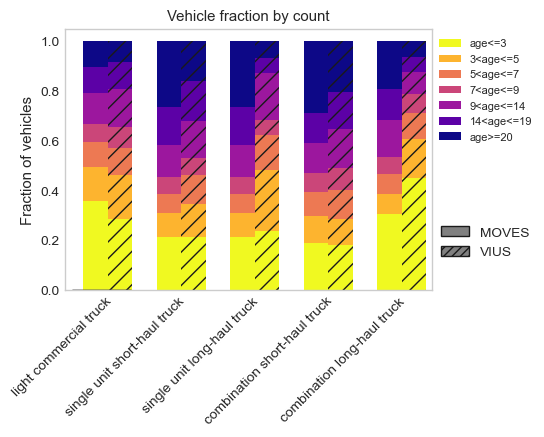

In [29]:
# normalized vehicle plot

vius_count_by_stmy.loc[:, age_bin_label] = \
    vius_count_by_stmy.loc[:, age_bin_label].div(vius_count_by_stmy.loc[:, age_bin_label].sum(axis=1), axis=0)

MOVES_count_by_stmy.loc[:, age_bin_label] = \
    MOVES_count_by_stmy.loc[:, age_bin_label].div(MOVES_count_by_stmy.loc[:, age_bin_label].sum(axis=1), axis=0)

plot_clustered_stacked([MOVES_count_by_stmy, vius_count_by_stmy],
                       ["MOVES", "VIUS"], 
                       'Vehicle fraction by count', 
                       'Fraction of vehicles')

plt.savefig('RawData/MOVES/plot/truck_frac_comparison_by_stmy.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()

## truck type and age distribution by VMT

In [30]:
# compare veh VMT by MOVES source type and age bin
# plot ST MY distribution

MOVES_fleet_selected = \
MOVES_fleet[['sourceTypeName', 'ageID', 'AGE_BIN', 
             'fuelTypeID', 'regClassID', 'weighted_vmt_by_hpms']]
MOVES_fleet_selected = \
MOVES_fleet_selected.drop_duplicates(keep = 'first')


MOVES_VMT_by_stmy = pd.pivot_table(MOVES_fleet_selected, 
                                   index = 'sourceTypeName',
                                  columns = 'AGE_BIN', 
                                   values = 'weighted_vmt_by_hpms',
                                  aggfunc = 'sum')

MOVES_VMT_by_stmy = MOVES_VMT_by_stmy.reset_index()
print(MOVES_VMT_by_stmy['sourceTypeName'].unique())

vius_VMT_by_stmy = pd.pivot_table(vius_fleet, 
                                  index = 'VEH_CLASS_MOVES',
                                  columns = 'AGE_BIN', 
                                  values = 'WGT_VMT',
                                  aggfunc = 'sum')
vius_VMT_by_stmy = vius_VMT_by_stmy.reset_index()
vius_VMT_by_stmy = \
vius_VMT_by_stmy.rename(columns = {'VEH_CLASS_MOVES': 'sourceTypeName'})

vius_VMT_by_stmy = vius_VMT_by_stmy.set_index('sourceTypeName')
MOVES_VMT_by_stmy = MOVES_VMT_by_stmy.set_index('sourceTypeName')

vius_VMT_by_stmy.head(5)


['combination long-haul truck' 'combination short-haul truck'
 'light commercial truck' 'single unit long-haul truck'
 'single unit short-haul truck']


AGE_BIN,14<age<=19,3<age<=5,5<age<=7,7<age<=9,9<age<=14,age<=3,age>=20
sourceTypeName,,,,,,,
combination long-haul truck,4.252610e+09,1.576460e+10,9.176631e+09,6.493858e+09,7.787084e+09,5.124483e+10,4.807144e+09
combination short-haul truck,3.032486e+09,3.912536e+09,3.765737e+09,2.683619e+09,3.819352e+09,7.290961e+09,3.084601e+09
light commercial truck,2.408989e+10,7.276688e+10,4.477912e+10,2.601138e+10,4.526922e+10,1.105456e+11,1.078811e+10
single unit long-haul truck,8.099797e+08,3.357069e+09,2.227948e+09,1.355435e+09,1.982183e+09,4.238684e+09,1.016762e+09
single unit short-haul truck,7.036287e+09,1.200816e+10,7.988527e+09,4.433158e+09,7.783942e+09,1.846459e+10,4.260692e+09


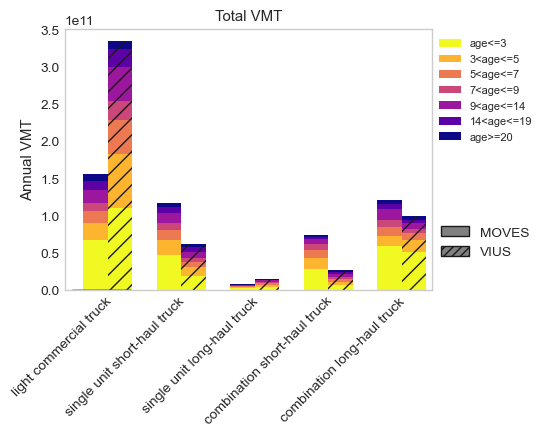

In [31]:
# plot stacked bar chart

vius_VMT_by_stmy = vius_VMT_by_stmy[age_bin_label]
vius_VMT_by_stmy = vius_VMT_by_stmy.loc[order_of_col]

MOVES_VMT_by_stmy = MOVES_VMT_by_stmy[age_bin_label]
MOVES_VMT_by_stmy = MOVES_VMT_by_stmy.loc[order_of_col]
plot_clustered_stacked([MOVES_VMT_by_stmy, vius_VMT_by_stmy],
                       ["MOVES", "VIUS"], 
                       'Total VMT', 
                       'Annual VMT')

plt.savefig('RawData/MOVES/plot/truck_vmt_comparison_by_stmy.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()

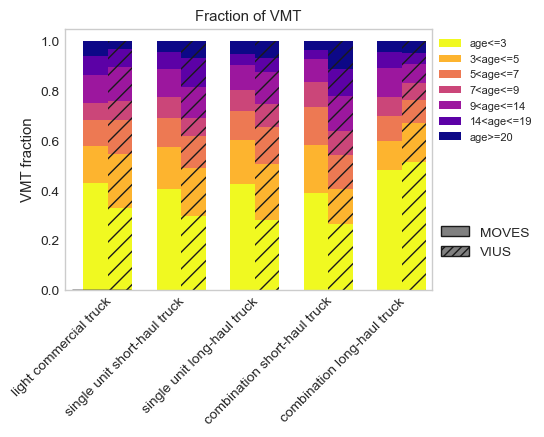

In [32]:
# plot normalized bar chart

vius_VMT_by_stmy.loc[:, age_bin_label] = \
    vius_VMT_by_stmy.loc[:, age_bin_label].div(vius_VMT_by_stmy.loc[:, age_bin_label].sum(axis=1), axis=0)

MOVES_VMT_by_stmy.loc[:, age_bin_label] = \
    MOVES_VMT_by_stmy.loc[:, age_bin_label].div(MOVES_VMT_by_stmy.loc[:, age_bin_label].sum(axis=1), axis=0)
plot_clustered_stacked([MOVES_VMT_by_stmy, vius_VMT_by_stmy],
                       ["MOVES", "VIUS"], 
                       'Fraction of VMT', 
                       'VMT fraction')

plt.savefig('RawData/MOVES/plot/truck_vmt_frac_comparison_by_stmy.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()

## annual mileage comparison

In [34]:
# VIUS VMT/truck

vius_stats_by_st_age = \
vius_fleet.groupby(['VEH_CLASS_MOVES', 'AGE_BIN'])[['TABWEIGHT','WGT_VMT']].sum()
vius_stats_by_st_age = vius_stats_by_st_age.reset_index()
vius_stats_by_st_age.loc[:, 'AGE_ORDER'] = \
vius_stats_by_st_age.loc[:, 'AGE_BIN'].map(age_bin_order)

vius_stats_by_st_age = \
vius_stats_by_st_age.sort_values(by = 'AGE_ORDER', ascending = True)

vius_stats_by_st_age.loc[:, 'ANNUAL_MILE_PER_TRUCK'] = \
vius_stats_by_st_age.loc[:, 'WGT_VMT'] / \
vius_stats_by_st_age.loc[:, 'TABWEIGHT']

moves_stats_by_st_age = \
MOVES_fleet.groupby(['sourceTypeName', 'AGE_BIN'])[['population_by_year_class','weighted_vmt_by_hpms']].sum()
moves_stats_by_st_age = moves_stats_by_st_age.reset_index()
moves_stats_by_st_age.loc[:, 'AGE_ORDER'] = \
moves_stats_by_st_age.loc[:, 'AGE_BIN'].map(age_bin_order)

moves_stats_by_st_age = \
moves_stats_by_st_age.sort_values(by = 'AGE_ORDER', ascending = True)

moves_stats_by_st_age.loc[:, 'ANNUAL_MILE_PER_TRUCK'] = \
moves_stats_by_st_age.loc[:, 'weighted_vmt_by_hpms'] / \
moves_stats_by_st_age.loc[:, 'population_by_year_class']

col_name = ['Vehicle type', 'Age bin', 'Annual mile per truck']
vius_stats_by_st_age = \
vius_stats_by_st_age[['VEH_CLASS_MOVES', 'AGE_BIN', 'ANNUAL_MILE_PER_TRUCK']]
vius_stats_by_st_age.columns = col_name
vius_stats_by_st_age.loc[:, 'Source'] = 'VIUS'
moves_stats_by_st_age = \
moves_stats_by_st_age[['sourceTypeName', 'AGE_BIN', 'ANNUAL_MILE_PER_TRUCK']]
moves_stats_by_st_age.columns = col_name
moves_stats_by_st_age.loc[:, 'Source'] = 'MOVES'
mileage_by_st_age = pd.concat([vius_stats_by_st_age,
                               moves_stats_by_st_age])


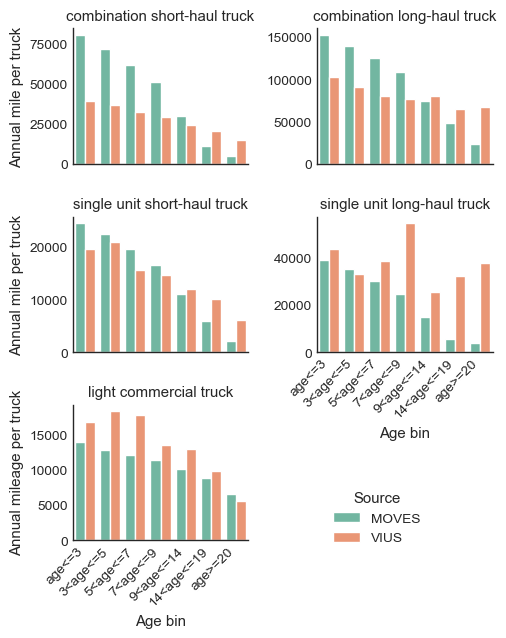

In [35]:
# plt.figure(figsize = (5, 5))
sns.set_style('white')
g = sns.catplot(mileage_by_st_age, 
            x="Age bin", y="Annual mile per truck", palette = 'Set2',
            col="Vehicle type", col_wrap = 2, hue = 'Source', 
            col_order = [                
                 'combination short-haul truck',
                 'combination long-haul truck',
                 'single unit short-haul truck',
                 'single unit long-haul truck', 
                 'light commercial truck' ], 
            hue_order = ['MOVES', 'VIUS'],
            kind = 'bar', height =2, aspect=1.3, sharey = False)

for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha("right")
plt.xlabel('Age bin')
plt.ylabel('Annual mileage per truck')
g.set_titles("{col_name}")
g._legend.set_bbox_to_anchor((0.7, 0.2))

plt.savefig('RawData/MOVES/plot/VMT_per_truck_by_type_age_compare.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()

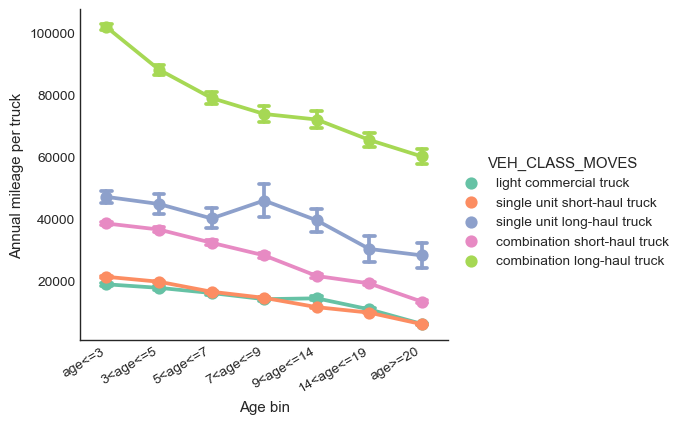

In [36]:
vius_fleet = \
vius_fleet.sort_values(by = 'VEH_AGE', ascending = True)
sns.catplot(x="AGE_BIN", y="MILESANNL",
             hue="VEH_CLASS_MOVES", hue_order=order_of_col,
             data=vius_fleet, capsize=.2, palette = 'Set2',
            errorbar="se", kind="point", height=4, aspect=1.25,)
plt.xticks(rotation = 30, ha= 'right')
plt.xlabel('Age bin')
plt.ylabel('Annual mileage per truck')
plt.savefig('RawData/MOVES/plot/VIUS_VMT_distribution_by_type_age.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()

## truck type and fuel distribution by count

In [38]:

print(MOVES_fleet.fuelTypeID.unique())
# 1- gas, 2 - diesel, 3 - CNG, 5 - E-85, 9 - elec
print(vius_fleet.FUELTYPE.unique())

vius_fleet_with_fuel = \
vius_fleet.loc[vius_fleet['FUELTYPE'] != 'Not reported']

vius_fleet_with_fuel.loc[:, 'fuelTypeName'] = \
vius_fleet_with_fuel.loc[:, 'FUELTYPE'].map(VIUS_fuel_lookup)

MOVES_fleet.loc[:, 'fuelTypeName'] = \
MOVES_fleet.loc[:, 'fuelTypeID'].map(MOVES_fuel_lookup)

print(vius_fleet_with_fuel['fuelTypeName'].unique())
print(MOVES_fleet['fuelTypeName'].unique())

[1 2 5 9 3]
['Diesel' 'Gasoline' 'Compressed natural gas' 'Not reported' 'Combination'
 'Propane' 'Electricity' 'Liquified natural gas' 'Alcohol fuels']
['Diesel' 'Gasoline' 'CNG' 'Other' 'Electricity']
['Gasoline' 'Diesel' 'Other' 'Electricity' 'CNG']


In [39]:
# compare fuel type

MOVES_count_by_fuel = pd.pivot_table(MOVES_fleet, index = 'sourceTypeName',
                                  columns = 'fuelTypeName', values = 'population_by_year_class',
                                  aggfunc = 'sum')

MOVES_count_by_fuel = MOVES_count_by_fuel.reset_index()
print(MOVES_count_by_fuel['sourceTypeName'].unique())
# MOVES_count_by_st

vius_count_by_fuel = pd.pivot_table(vius_fleet_with_fuel, 
                                    index = 'VEH_CLASS_MOVES',
                                  columns = 'fuelTypeName', 
                                    values = 'TABWEIGHT',
                                  aggfunc = 'sum')
vius_count_by_fuel = vius_count_by_fuel.reset_index()

vius_count_by_fuel = \
vius_count_by_fuel.rename(columns = {'VEH_CLASS_MOVES': 'sourceTypeName'})


vius_count_by_fuel = vius_count_by_fuel.set_index('sourceTypeName')
MOVES_count_by_fuel = MOVES_count_by_fuel.set_index('sourceTypeName')

vius_count_by_fuel.head(5)

['combination long-haul truck' 'combination short-haul truck'
 'light commercial truck' 'single unit long-haul truck'
 'single unit short-haul truck']


fuelTypeName,CNG,Diesel,Electricity,Gasoline,Other
sourceTypeName,,,,,
combination long-haul truck,4731.0,1089430.1,NaN,185.9,1761.4
combination short-haul truck,2892.8,989717.3,NaN,1881.7,2272.4
light commercial truck,NaN,1289289.7,38571.0,20921129.5,242792.7
single unit long-haul truck,696.5,293534.8,NaN,113289.5,565.9
single unit short-haul truck,23132.8,2828151.5,312.3,1424991.6,13189.9


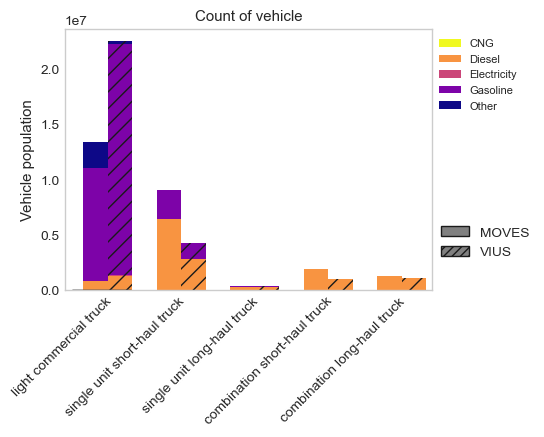

In [40]:

vius_count_by_fuel = vius_count_by_fuel.loc[order_of_col]

MOVES_count_by_fuel = MOVES_count_by_fuel.loc[order_of_col]
sns.set(font_scale=0.9)  # normal font 
plt.style.use('seaborn-v0_8-whitegrid')
plot_clustered_stacked([MOVES_count_by_fuel, vius_count_by_fuel],
                       ["MOVES", "VIUS"], 
                       'Count of vehicle', 
                       'Vehicle population')

plt.savefig('RawData/MOVES/plot/truck_count_comparison_by_fuel.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()


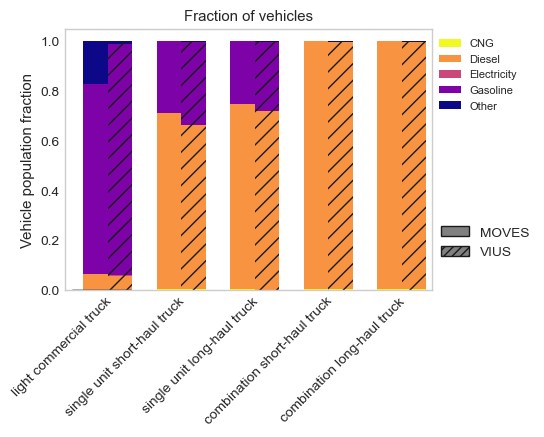

In [41]:
# plot normalized bar chart
fuel_types = vius_fleet_with_fuel['fuelTypeName'].unique()
vius_count_by_fuel.loc[:, fuel_types] = \
    vius_count_by_fuel.loc[:, fuel_types].div(vius_count_by_fuel.loc[:, fuel_types].sum(axis=1), axis=0)

MOVES_count_by_fuel.loc[:, fuel_types] = \
    MOVES_count_by_fuel.loc[:, fuel_types].div(MOVES_count_by_fuel.loc[:, fuel_types].sum(axis=1), axis=0)
plot_clustered_stacked([MOVES_count_by_fuel, vius_count_by_fuel],
                       ["MOVES", "VIUS"], 
                       'Fraction of vehicles', 
                       'Vehicle population fraction')

plt.savefig('RawData/MOVES/plot/truck_frac_comparison_by_fuel.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()

## truck type and fuel distribution by VMT

In [42]:
# VMT by fuel type

MOVES_VMT_by_fuel = pd.pivot_table(MOVES_fleet, 
                                   index = 'sourceTypeName',
                                  columns = 'fuelTypeName', 
                                   values = 'weighted_vmt_by_hpms',
                                  aggfunc = 'sum')

MOVES_VMT_by_fuel = MOVES_VMT_by_fuel.reset_index()
print(MOVES_VMT_by_fuel['sourceTypeName'].unique())
# MOVES_count_by_st

vius_VMT_by_fuel = pd.pivot_table(vius_fleet_with_fuel, 
                                  index = 'VEH_CLASS_MOVES',
                                  columns = 'fuelTypeName', 
                                  values = 'WGT_VMT',
                                  aggfunc = 'sum')
vius_VMT_by_fuel = vius_VMT_by_fuel.reset_index()
vius_VMT_by_fuel = \
vius_VMT_by_fuel.rename(columns = {'VEH_CLASS_MOVES': 'sourceTypeName'})

vius_VMT_by_fuel = vius_VMT_by_fuel.set_index('sourceTypeName')
MOVES_VMT_by_fuel = MOVES_VMT_by_fuel.set_index('sourceTypeName')

vius_VMT_by_fuel.head(5)


['combination long-haul truck' 'combination short-haul truck'
 'light commercial truck' 'single unit long-haul truck'
 'single unit short-haul truck']


fuelTypeName,CNG,Diesel,Electricity,Gasoline,Other
sourceTypeName,,,,,
combination long-haul truck,570771644.2,9.802212e+10,NaN,9.672889e+06,1.363857e+08
combination short-haul truck,121142282.3,2.671844e+10,NaN,4.603726e+07,4.182861e+07
light commercial truck,NaN,1.717365e+10,367835880.9,3.091563e+11,3.230634e+09
single unit long-haul truck,21595879.0,1.121156e+10,NaN,3.674741e+09,1.732653e+07
single unit short-haul truck,459295107.5,4.065186e+10,7010418.3,1.912077e+10,2.741604e+08


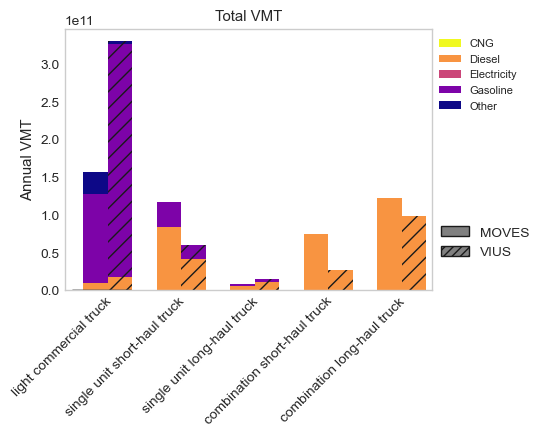

In [43]:
#plot fuel type distribution BY vmt


vius_VMT_by_fuel = vius_VMT_by_fuel.loc[order_of_col]

MOVES_VMT_by_fuel = MOVES_VMT_by_fuel.loc[order_of_col]
plot_clustered_stacked([MOVES_VMT_by_fuel, vius_VMT_by_fuel],
                       ["MOVES", "VIUS"], 
                       'Total VMT', 
                       'Annual VMT')

plt.savefig('RawData/MOVES/plot/truck_VMT_comparison_by_fuel.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()


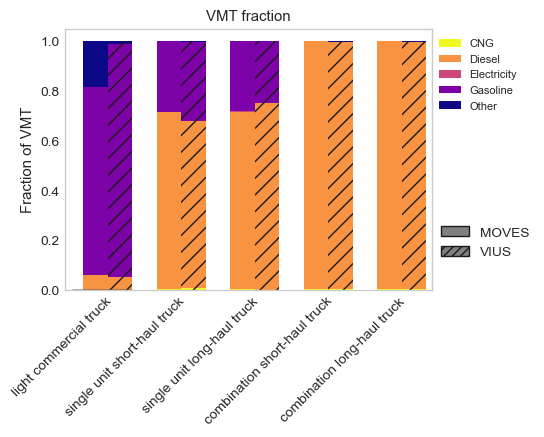

In [44]:
# plot normalized bar chart
fuel_types = vius_fleet_with_fuel['fuelTypeName'].unique()
vius_VMT_by_fuel.loc[:, fuel_types] = \
    vius_VMT_by_fuel.loc[:, fuel_types].div(vius_VMT_by_fuel.loc[:, fuel_types].sum(axis=1), axis=0)

MOVES_VMT_by_fuel.loc[:, fuel_types] = \
    MOVES_VMT_by_fuel.loc[:, fuel_types].div(MOVES_VMT_by_fuel.loc[:, fuel_types].sum(axis=1), axis=0)
plot_clustered_stacked([MOVES_VMT_by_fuel, vius_VMT_by_fuel],
                       ["MOVES", "VIUS"], 
                       'VMT fraction', 
                       'Fraction of VMT')

plt.savefig('RawData/MOVES/plot/truck_VMT_frac_comparison_by_fuel.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()

## truck type and reg class distribution by count

In [45]:
# plot ST RegClass distribution

MOVES_fleet_selected = \
MOVES_fleet[['sourceTypeName', 'ageID', 'AGE_BIN', 
             'fuelTypeID', 'regClassName', 'population_by_year_class']]
MOVES_fleet_selected = MOVES_fleet_selected.drop_duplicates(keep = 'first')
hhd_index = (MOVES_fleet_selected['regClassName'] == 'HHD8 (w. glider)')
MOVES_fleet_selected.loc[hhd_index, 'regClassName'] = 'HHD8'     
print(MOVES_fleet_selected.regClassName.unique())
MOVES_count_by_streg = pd.pivot_table(MOVES_fleet_selected, index = 'sourceTypeName',
                                  columns = 'regClassName', values = 'population_by_year_class',
                                  aggfunc = 'sum')

MOVES_count_by_streg = MOVES_count_by_streg.reset_index()
print(MOVES_count_by_streg['sourceTypeName'].unique())
# MOVES_count_by_st
hhd_index = (vius_fleet['regClassName'] == 'HHD8 (w. glider)')
vius_fleet.loc[hhd_index, 'regClassName'] = 'HHD8'    
vius_count_by_streg = pd.pivot_table(vius_fleet, index = 'VEH_CLASS_MOVES',
                                  columns = 'regClassName', values = 'TABWEIGHT',
                                  aggfunc = 'sum')
vius_count_by_streg = vius_count_by_streg.reset_index()

vius_count_by_streg = \
vius_count_by_streg.rename(columns = {'VEH_CLASS_MOVES': 'sourceTypeName'})

vius_count_by_streg = vius_count_by_streg.set_index('sourceTypeName')
vius_count_by_streg = vius_count_by_streg.fillna(0)
MOVES_count_by_streg = MOVES_count_by_streg.set_index('sourceTypeName')
MOVES_count_by_streg = MOVES_count_by_streg.fillna(0)
vius_count_by_streg.head(5)

['LDT' 'LHD2b3' 'LHD45' 'MHD67' 'HHD8']
['combination long-haul truck' 'combination short-haul truck'
 'light commercial truck' 'single unit long-haul truck'
 'single unit short-haul truck']


regClassName,HHD8,LDT,LHD2b3,LHD45,MHD67
sourceTypeName,,,,,
combination long-haul truck,1073585.7,0.0,0.0,0.0,29948.2
combination short-haul truck,929164.3,0.0,0.0,0.0,88040.5
light commercial truck,0.0,18062049.8,4778805.6,0.0,0.0
single unit long-haul truck,52775.3,0.0,204106.5,61834.2,91344.8
single unit short-haul truck,662812.9,0.0,1805731.3,996201.7,904776.8


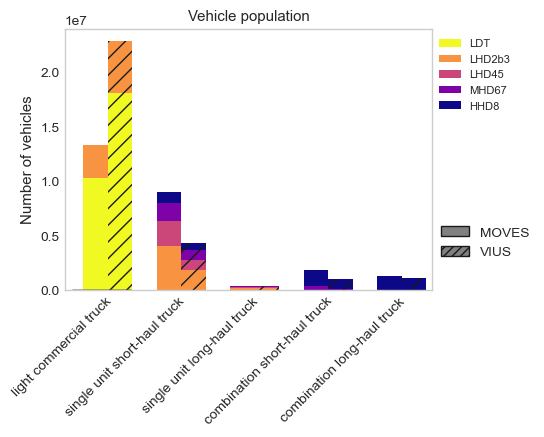

In [46]:
# plot stacked bar chart
order_of_reg = ['LDT', 'LHD2b3', 'LHD45', 'MHD67', 'HHD8']
vius_count_by_streg = vius_count_by_streg[order_of_reg]
vius_count_by_streg = vius_count_by_streg.loc[order_of_col]

MOVES_count_by_streg = MOVES_count_by_streg[order_of_reg]
MOVES_count_by_streg = MOVES_count_by_streg.loc[order_of_col]
sns.set(font_scale=0.9)  # normal font 
plt.style.use('seaborn-v0_8-whitegrid')
plot_clustered_stacked([MOVES_count_by_streg, vius_count_by_streg],
                       ["MOVES", "VIUS"], 
                       'Vehicle population', 
                       'Number of vehicles')

plt.savefig('RawData/MOVES/plot/truck_count_comparison_by_streg.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()

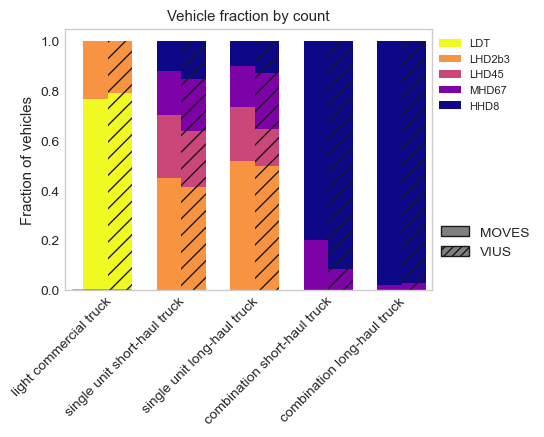

In [47]:
# normalized vehicle plot

vius_count_by_streg.loc[:, order_of_reg] = \
    vius_count_by_streg.loc[:, order_of_reg].div(vius_count_by_streg.loc[:, order_of_reg].sum(axis=1), axis=0)

MOVES_count_by_streg.loc[:, order_of_reg] = \
    MOVES_count_by_streg.loc[:, order_of_reg].div(MOVES_count_by_streg.loc[:, order_of_reg].sum(axis=1), axis=0)

plot_clustered_stacked([MOVES_count_by_streg, vius_count_by_streg],
                       ["MOVES", "VIUS"], 
                       'Vehicle fraction by count', 
                       'Fraction of vehicles')

plt.savefig('RawData/MOVES/plot/truck_frac_comparison_by_streg.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()

## truck type and reg class distribution by VMT

In [48]:
# compare veh VMT by MOVES source type and reg class
# plot ST MY distribution

MOVES_fleet_selected = \
MOVES_fleet[['sourceTypeName', 'ageID', 'AGE_BIN', 
             'fuelTypeID', 'regClassName', 'weighted_vmt_by_hpms']]
MOVES_fleet_selected = \
MOVES_fleet_selected.drop_duplicates(keep = 'first')
hhd_index = (MOVES_fleet_selected['regClassName'] == 'HHD8 (w. glider)')
MOVES_fleet_selected.loc[hhd_index, 'regClassName'] = 'HHD8'    

MOVES_VMT_by_streg = pd.pivot_table(MOVES_fleet_selected, 
                                   index = 'sourceTypeName',
                                  columns = 'regClassName', 
                                   values = 'weighted_vmt_by_hpms',
                                  aggfunc = 'sum')

MOVES_VMT_by_streg = MOVES_VMT_by_streg.reset_index()
print(MOVES_VMT_by_streg['sourceTypeName'].unique())
# MOVES_count_by_st

vius_VMT_by_streg = pd.pivot_table(vius_fleet, 
                                  index = 'VEH_CLASS_MOVES',
                                  columns = 'regClassName', 
                                  values = 'WGT_VMT',
                                  aggfunc = 'sum')
vius_VMT_by_streg = vius_VMT_by_streg.reset_index()
vius_VMT_by_streg = \
vius_VMT_by_streg.rename(columns = {'VEH_CLASS_MOVES': 'sourceTypeName'})

vius_VMT_by_streg = vius_VMT_by_streg.set_index('sourceTypeName')
MOVES_VMT_by_streg = MOVES_VMT_by_streg.set_index('sourceTypeName')

vius_VMT_by_streg.head(5)

['combination long-haul truck' 'combination short-haul truck'
 'light commercial truck' 'single unit long-haul truck'
 'single unit short-haul truck']


regClassName,HHD8,LDT,LHD2b3,LHD45,MHD67
sourceTypeName,,,,,
combination long-haul truck,9.671307e+10,NaN,NaN,NaN,2.813684e+09
combination short-haul truck,2.579266e+10,NaN,NaN,NaN,1.796634e+09
light commercial truck,NaN,2.659717e+11,6.827848e+10,NaN,NaN
single unit long-haul truck,3.133568e+09,NaN,5.488545e+09,2.346573e+09,4.019375e+09
single unit short-haul truck,1.049152e+10,NaN,2.581990e+10,1.325909e+10,1.240484e+10


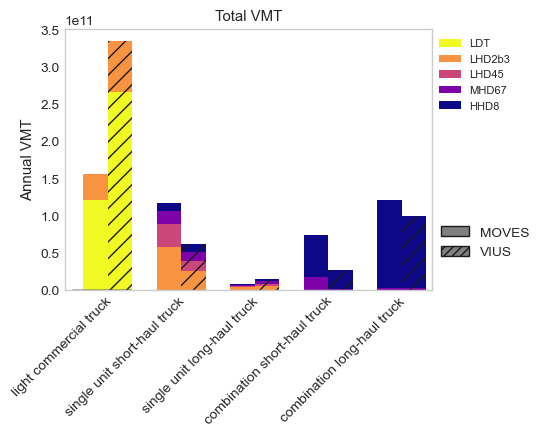

In [49]:
# plot stacked bar chart

vius_VMT_by_streg = vius_VMT_by_streg[order_of_reg]
vius_VMT_by_streg = vius_VMT_by_streg.loc[order_of_col]

MOVES_VMT_by_streg = MOVES_VMT_by_streg[order_of_reg]
MOVES_VMT_by_streg = MOVES_VMT_by_streg.loc[order_of_col]
plot_clustered_stacked([MOVES_VMT_by_streg, vius_VMT_by_streg],
                       ["MOVES", "VIUS"], 
                       'Total VMT', 
                       'Annual VMT')

plt.savefig('RawData/MOVES/plot/truck_vmt_comparison_by_streg.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()

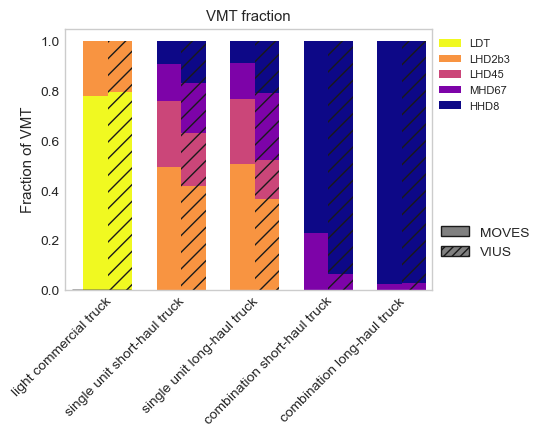

In [50]:
# normalized vehicle plot

vius_VMT_by_streg.loc[:, order_of_reg] = \
    vius_VMT_by_streg.loc[:, order_of_reg].div(vius_VMT_by_streg.loc[:, order_of_reg].sum(axis=1), axis=0)

MOVES_VMT_by_streg.loc[:, order_of_reg] = \
    MOVES_VMT_by_streg.loc[:, order_of_reg].div(MOVES_VMT_by_streg.loc[:, order_of_reg].sum(axis=1), axis=0)

plot_clustered_stacked([MOVES_VMT_by_streg, vius_VMT_by_streg],
                       ["MOVES", "VIUS"], 
                       'VMT fraction', 
                       'Fraction of VMT')

plt.savefig('RawData/MOVES/plot/truck_vmt_frac_comparison_by_streg.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()